# 2.3. Experiments

Assuming one table schema, 100 attributes, and each attribute being 10 bytes each, we have met the criteria for a fixed length record data scheme. Based on this data we know each record will be 1000 bytes to serialize.

A record in our sense (defined with `std::vector<V> Record`) is an array of strings. In our experiment (which can be viewed in experiment_fixed_len_sizeof.cc) we initialize a Record of 100 strings:

```c
Record record = {
    "SQHVXJTXOK",
    "NABHDFBCWB",
    "XAWTEBKZWL",
    "OBPQAPWYKC",
    "RJESFTAEUK",
    "NSCLEQRJVJ",
    "RAYZKLAIEN",
    "SHVLBDTEHU",
    ...,
}
```

Once complete, we run `fixed_len_sizeof(&record)` which calculates the amount of bytes it takes to serialize this record.

```bash
bash-3.2$ ./experiment_fixed_len_sizeof
1000
```

Experiments here were done on a Macbook Pro 2014 13' edition.

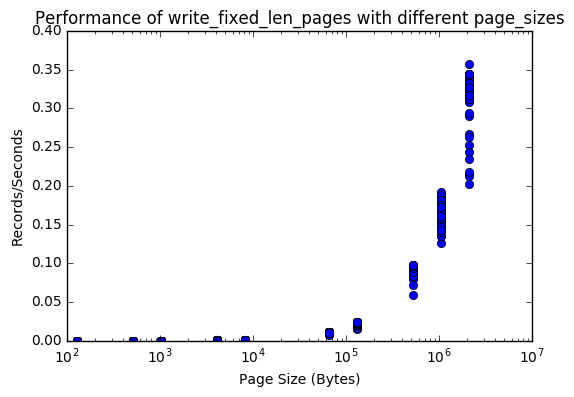

In [6]:
%matplotlib inline

import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure

def get_data(csvfile):
    reader = csv.DictReader(csvfile)
    return zip(*[
        (
            row['page_size'], 
            row['milliseconds_elapsed'],
            # calculate data rate: mebibytes / second
            (
                # convert bytes -> mebibytes
                (int(row['page_size']) / 2 ** 20)
                /
                # convert milliseconds -> seconds
                100/(int(row['milliseconds_elapsed']) / 1000)
            )
        )
        for row in reader
    ])

with open('./results_write.csv') as csvfile:
    x, y, rates = get_data(csvfile)
    
    plt.title(
        'Performance of write_fixed_len_pages ' +
        'with different page_sizes'
    )
    plt.xlabel('Page Size (Bytes)')
    plt.ylabel('Records/Seconds')
    plt.xscale('log')
    plt.plot(x, rates, 'bo')
    
    plt.show()

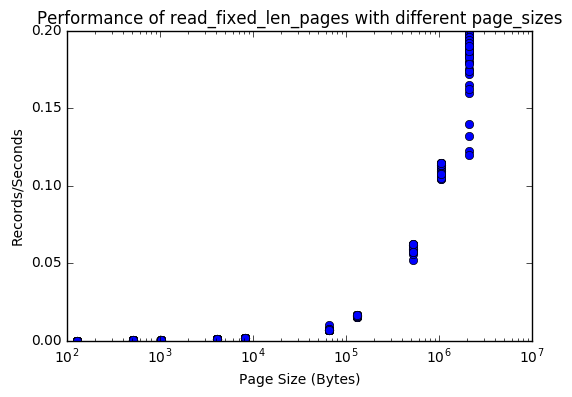

In [5]:
%matplotlib inline

import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import figure

def get_data(csvfile):
    reader = csv.DictReader(csvfile)
    return zip(*[
        (
            row['page_size'], 
            row['milliseconds_elapsed'],
            # calculate data rate: mebibytes / second
            (
                # convert bytes -> mebibytes
                (int(row['page_size']) / 2 ** 20)
                /
                # convert milliseconds -> seconds
                100/(int(row['milliseconds_elapsed']) / 1000)
            )
        )
        for row in reader
    ])

with open('./results_read.csv') as csvfile:
    x, y, rates = get_data(csvfile)
    
    plt.title(
        'Performance of read_fixed_len_pages ' +
        'with different page_sizes'
    )
    plt.xlabel('Page Size (Bytes)')
    plt.ylabel('Records/Seconds')
    plt.xscale('log')
    plt.plot(x, rates, 'bo')
    
    plt.show()

There are several reasons why storing records in a page-based format is superior to using a CSV file:
* The page file does not need to store delimiters (commas and newlines) that must be stored in the CSV file, saving space.
* The page file can store numeric values in their binary format instead of as strings as in the CSV file, saving space.
* Records can be deleted from the page file very quickly: only the entry in the page's directory must be changed. In the CSV file, subsequent rows must be shifted when a row is deleted.

Our pages are organized with a directory located at the end of the page (as a bitmap indicating which blocks are free and occupied), and block data starting at the beginning of the page. One downside to this structure is that some space is wasted in the region between the last data block and the beginning of the directory. Another downside is that records must be a fixed size to store in this page structure, so they can be addressed by the bitmap directory.